# Лабораторная работа №7

Бирюков В. В.

Группа: М8О-407Б-19

In [1]:
!pip install onnxruntime-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.2/136.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.3 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.transforms import v2 as transforms2
from PIL import Image
import tqdm
from collections import defaultdict
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import onnxruntime as onnxrt

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def plot_image(ax, image, interp='nearest'):    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set(aspect='equal')
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    ax.imshow(np.clip(np.array(image).transpose(1, 2, 0) * std + mean, 0, 1), interpolation=interp)

def plot_images(images, indexes=None, w=7, h=None, titles=None, interp='nearest'):
    indexes = range(len(images)) if indexes is None else indexes
    
    w = min(w, len(images))
    h = h or (len(indexes) - 1) // w + 1
    assert(w * h >= len(indexes))
    
    fig = plt.figure(figsize=(w * 2.5, h * 2.5))
    for i, k in enumerate(indexes, 1):
        ax = fig.add_subplot(h, w, i)
        plot_image(ax, images[k], interp=interp)
        if titles is not None and k < len(titles):
            ax.set_title(titles[k])
    
    plt.show()

def plot_history(history, *metrics):
    for metric in metrics:
        print(f"train_{metric}: {history[f'train_{metric}'][-1]:.4f}")
        print(f"val_{metric}: {history[f'val_{metric}'][-1]:.4f}")
    figure = plt.figure(figsize=(5.5 * len(metrics), 3.5))
    for i, metric in enumerate(metrics, 1):
        ax = figure.add_subplot(1, len(metrics), i)
        ax.xaxis.get_major_locator().set_params(integer=True)
        ax.set_title(metric)
        ax.plot(history[f'train_{metric}'], '-', label='train')
        ax.plot(history[f'val_{metric}'], '-', label='val')
        ax.legend()
    plt.show()

def plot_results(model, dataloader, num_images=6):
    model.eval()
    images = []
    titles = []
    
    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, preds = torch.max(outputs, 1)

            for j in range(data.size()[0]):
                images.append(data[j].cpu())
                titles.append(class_names[preds[j]])
                
                if preds[j] != labels[j]:
                    titles[-1] += f' ({class_names[labels[j]]})'

                if len(images) == num_images:
                    break

            if len(images) == num_images:
                    break
        
    plot_images(images, titles=titles)

def plot_confusion_matrix(model, dataloader):
    model.eval()
    target = []
    pred = []
    
    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            target.extend(labels)

            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, preds = torch.max(outputs, 1)

            pred.extend(preds.detach().cpu())

    conf = confusion_matrix(target, pred)

    fig = plt.figure(figsize=(6 / 0.95, 6))
    axes = fig.subplots(1, 2, width_ratios=[0.95, 0.05])
    sns.heatmap(conf, cmap='viridis', xticklabels=[], yticklabels=[], square=True, annot=False, ax=axes[0], cbar_ax=axes[1], robust=True)
    fig.tight_layout()
    plt.show()

In [5]:
class ImageDataset(Dataset):
    def __init__(self, paths, targets, transform=None):
        assert(len(paths) == len(targets))
        self.paths = paths
        self.targets = targets
        self.transform = transform

    def load_image(self, index):
        image_path = self.paths[index]
        return Image.open(image_path).convert(mode='RGB')
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img = self.load_image(index)
        target = self.targets[index]

        if self.transform:
            return self.transform(img), target
        else:
            return img, target

## Загрузка данных

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from google.colab import files
files.upload()
pass

Saving kaggle.json to kaggle.json


In [8]:
!pip install -q kaggle

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d jessicali9530/caltech256

100% 2.12G/2.12G [01:18<00:00, 35.8MB/s]
100% 2.12G/2.12G [01:18<00:00, 29.2MB/s]


In [11]:
!unzip -q caltech256

## Подготовка данных

In [12]:
# root = '/kaggle/input/caltech256/'
root = './'

In [13]:
def read_images_labels(path):
    images = []
    labels = []
    with open(path, 'rt') as f:
        for line in f:
            image, label = line.split(' ')[:2]
            images.append(root + image)
            labels.append(int(label))
    return images, labels

In [14]:
train_images, train_labels = read_images_labels('drive/MyDrive/aidl/lab7/train_lst.txt')
val_images, val_labels = read_images_labels('drive/MyDrive/aidl/lab7/val_lst.txt')
# train_images, train_labels = read_images_labels('/kaggle/input/caltech-256-train-val-split/train_lst.txt')
# val_images, val_labels = read_images_labels('/kaggle/input/caltech-256-train-val-split/val_lst.txt')

In [15]:
train_transforms = transforms.Compose([
    transforms2.RandomResize(256, 480),
    transforms.RandomRotation(45),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.RandomErasing(0.1),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [16]:
train_dataset = ImageDataset(train_images, train_labels, train_transforms)
val_dataset = ImageDataset(val_images, val_labels, val_transforms)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

In [18]:
class_names = [i[4:] for i in sorted(os.listdir(root + '256_ObjectCategories'))]

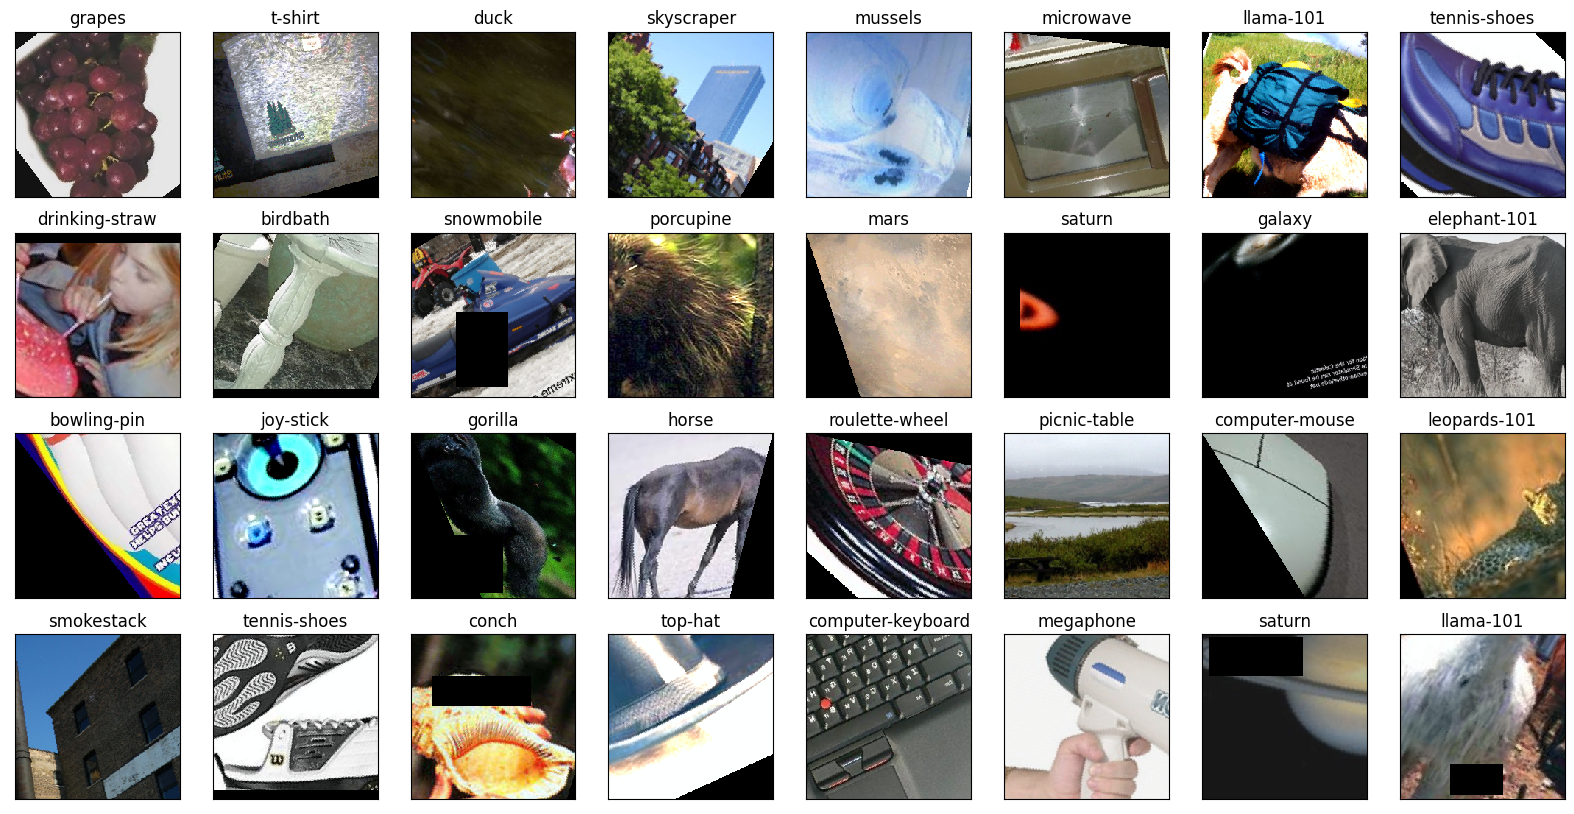

In [ ]:
inputs, classes = next(iter(train_loader))

plot_images(inputs, titles=[class_names[x] for x in classes], w=8)

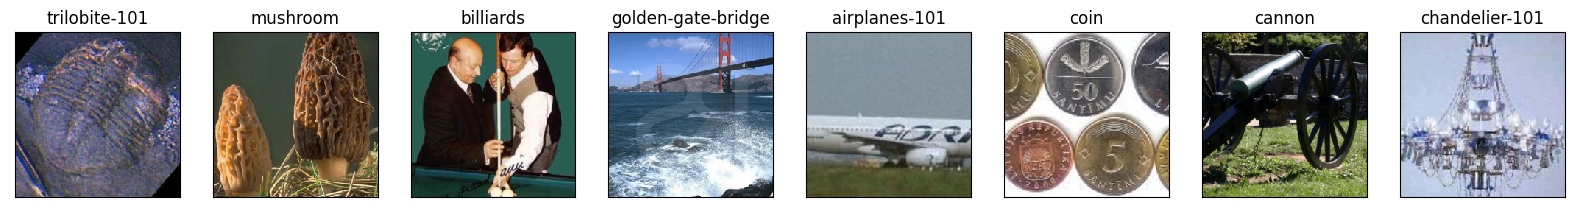

In [ ]:
inputs, classes = next(iter(val_loader))

plot_images(inputs, titles=[class_names[x] for x in classes], indexes=range(8), w=8)

## Обучение

In [19]:
def mixup(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    new_data = data * lam + shuffled_data * (1 - lam)
    new_targets = [targets, shuffled_targets, lam]
    return new_data, new_targets

def cutmix(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    new_targets = [targets, shuffled_targets, lam]
    return data, new_targets
        
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def mix_criterion(criterion, preds, targets):
    targets1, targets2, lam = targets[0], targets[1], targets[2]
    return lam * criterion(preds, targets1) + (1 - lam) * criterion(preds, targets2)

def mix_accuracy(preds, targets):
    targets1, targets2, lam = targets[0], targets[1], targets[2]
    return lam * (preds == targets1).sum() + (1 - lam) * (preds == targets2).sum()

In [20]:
def validate(model, criterion, dataloader):
    model.eval()
    avg_loss = 0
    avg_acc = 0
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)

            output = model(data)
            _, pred = torch.max(output, 1)
            loss = criterion(output, labels)

            avg_loss += loss.item() * len(data) / len(val_loader.dataset)
            avg_acc += torch.sum(labels == pred).item()
    return avg_loss, avg_acc / len(val_loader.dataset)

def fit(model, optimizer, criterion, scheduler, epochs, train_loader, val_loader, p_mix, mixup_alpha, cutmix_alpha):
    model.train()

    history = defaultdict(list)
    pbar = tqdm.trange(epochs, ascii=True)
    for epoch in pbar:
        avg_loss = 0
        avg_acc = 0
        for data, labels in train_loader:
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            p = np.random.rand()
            if p < p_mix:
                if np.random.rand() < 0.5:
                    data, labels = mixup(data, labels, mixup_alpha)
                else:
                    data, labels = cutmix(data, labels, cutmix_alpha)
            
            output = model(data)
            _, pred = torch.max(output, 1)
            if p < p_mix:
                loss = mix_criterion(criterion, output, labels)
            else:
                loss = criterion(output, labels)
            
            loss.backward()
            
            optimizer.step()
            avg_loss += loss.item() * len(data) / len(train_loader.dataset)
            if p < p_mix:
                avg_acc += mix_accuracy(pred, labels).item()
            else:
                avg_acc += torch.sum(labels == pred).item()
        
        history['train_loss'].append(avg_loss)
        history['train_accuracy'].append(avg_acc / len(train_loader.dataset))
        
        if scheduler is not None:
            scheduler.step()

        avg_loss, avg_acc = validate(model, criterion, val_loader)
        model.train()
        history['val_loss'].append(avg_loss)
        history['val_accuracy'].append(avg_acc)

        pbar.set_description(f"Epoch: {epoch+1}. Train loss: {history['train_loss'][-1]:.4f}. Val loss: {history['val_loss'][-1]:.4f}. Train acc: {history['train_accuracy'][-1]:.4f}. Val acc: {history['val_accuracy'][-1]:.4f}")
    
    with torch.no_grad():
        torch.cuda.empty_cache()
    return history

In [21]:
def validate_onnx(session, dataloader):
    correct = 0
    for data, labels in tqdm.tqdm(dataloader, ascii=True):
        labels = labels.numpy()
        output = session.run(None, {'input': data.numpy()})
        pred = np.argmax(output[0], 1)
        correct += (labels == pred).sum()
    return correct / len(dataloader.dataset)

### Готовый resnet18

#### Подбор параметров

Первая версия. Использованы только самые простые аугментации: RandomResize, RandomRotation, RandomHorizontalFlip. Явно наблюдается переобучение

(Здесь и далее значения ошибки отличаются от итоговых, из-за не совсем корректного метода подсчета)

In [ ]:
resnet = models.resnet18()
resnet.fc = nn.Linear(resnet.fc.in_features, len(class_names))
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 40)

In [ ]:
history = fit(resnet, optimizer, criterion, 40, train_loader, val_loader, scheduler)

Epoch: 40. Train loss: 0.0680. Val loss: 0.0923. Train acc: 0.6871. Val acc: 0.5213: 100%|##########| 40/40 [1:59:07<00:00, 178.70s/it]


train_loss: 0.0680
val_loss: 0.0923
train_accuracy: 0.6871
val_accuracy: 0.5213


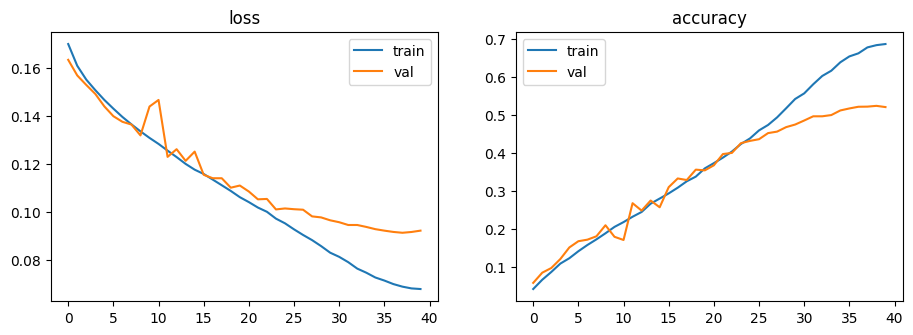

In [ ]:
plot_history(history, 'loss', 'accuracy')

Оптимизатор, шедулер и гиперпараметры решено оставить такими же. К аугментациям добавлен TrivialAugmentWide. Переобучение пропадает (по крайней мере на таком количестве эпох)

train_loss: 0.0922
val_loss: 0.0916
train_accuracy: 0.4768
val_accuracy: 0.5082


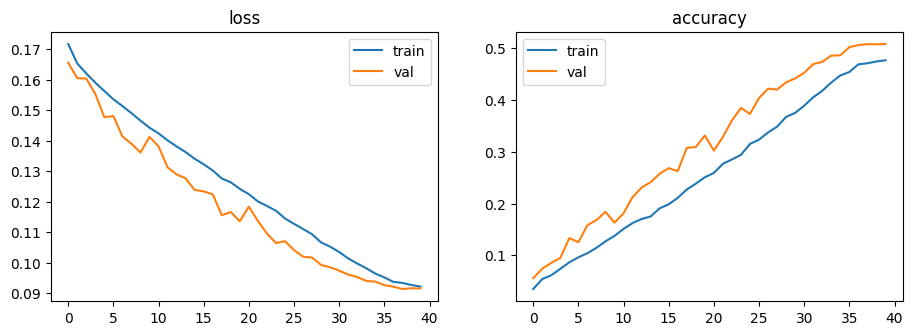

In [ ]:
plot_history(history, 'loss', 'accuracy')

К аугментациям добавлен RandomErasing. Результат примерно такой же

train_loss: 0.0917
val_loss: 0.0902
train_accuracy: 0.4826
val_accuracy: 0.5164


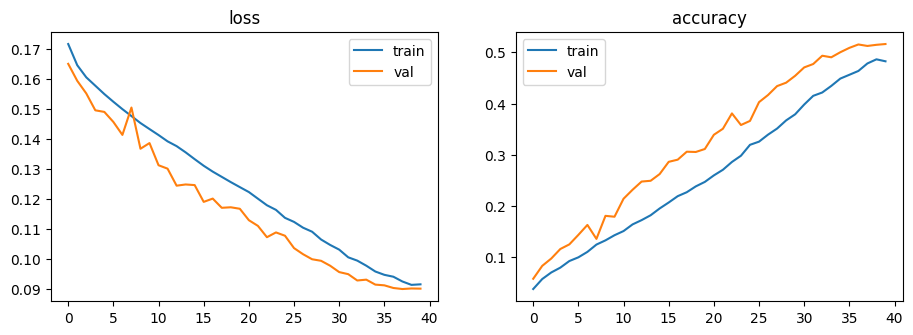

In [ ]:
plot_history(history, 'loss', 'accuracy')

К методам регуляризации добавлены mixup и cutmix. Точность остается такой же, однако разрыв между валидацией и обучением становится больше

train_loss: 0.0996
val_loss: 0.0910
train_accuracy: 0.4387
val_accuracy: 0.5092


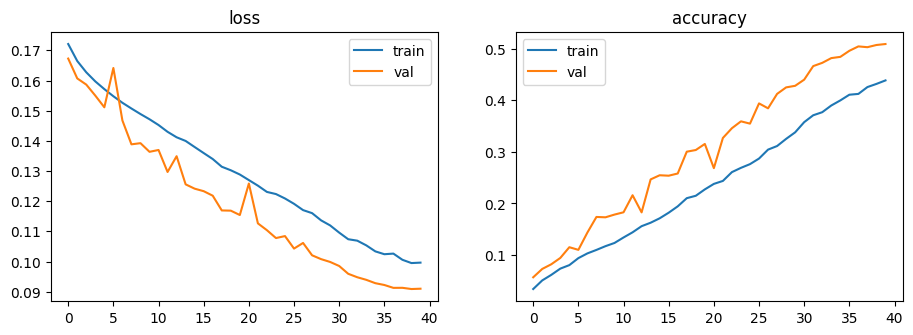

In [ ]:
plot_history(history, 'loss', 'accuracy')

#### Итоговая версия

In [ ]:
resnet = models.resnet18()
resnet.fc = nn.Linear(resnet.fc.in_features, len(class_names))
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 65)

In [ ]:
history = fit(resnet, optimizer, criterion, scheduler, 65, train_loader, val_loader, 0.2, 0.2, 1)

Epoch: 65. Train loss: 2.5061. Val loss: 2.5435. Train acc: 0.6101. Val acc: 0.6039: 100%|##########| 65/65 [2:35:46<00:00, 143.79s/it]  


train_loss: 2.5061
val_loss: 2.5435
train_accuracy: 0.6101
val_accuracy: 0.6039


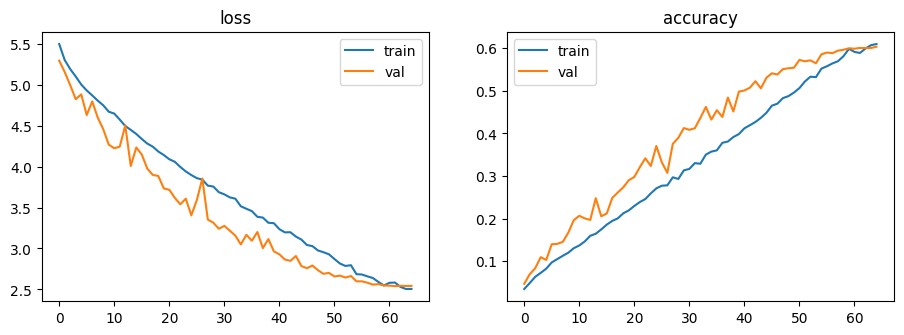

In [ ]:
plot_history(history, 'loss', 'accuracy')

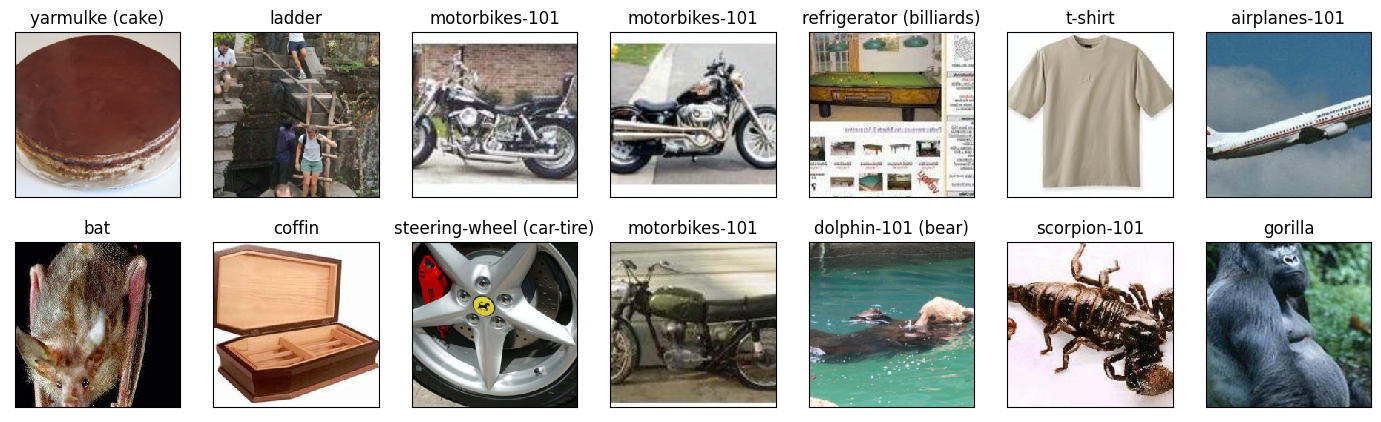

In [ ]:
plot_results(resnet, val_loader, 14)

Матрица ошибок. Так как при таком масштабе оттенки практически не видны, все встреченные комбинации выделены одинаково.

Видно, что для практически для каждого класса сделано хотя бы одно верное предсказание

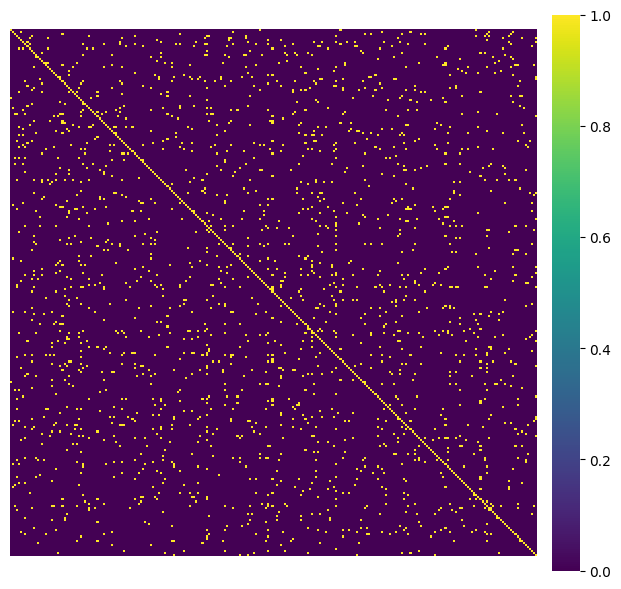

In [ ]:
plot_confusion_matrix(resnet, val_loader)

In [ ]:
torch.save(resnet, 'drive/MyDrive/aidl/lab7/resnet.pkl')

Экспорт в ONNX и сравнение точности. Результаты совпадают с точностью до третьего знака

In [ ]:
ex_input = torch.zeros(32, 3, 224, 224, device=device)
torch.onnx.export(resnet, ex_input, 'drive/MyDrive/aidl/lab7/resnet.onnx', 
                  input_names = ['input'], output_names = ['output'], 
                  dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}})

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================


In [37]:
session = onnxrt.InferenceSession('drive/MyDrive/aidl/lab7/resnet.onnx', providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])
acc = validate_onnx(session, val_loader)
print(f'\nONNX accuracy: {acc:.4f}')

100%|##########| 184/184 [00:36<00:00,  5.04it/s]


ONNX accuracy: 0.6042


### Cобственная реализация resnet18

In [22]:
class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResnetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=(1 + (in_channels != out_channels)), padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            x = self.downsample(x)
        return self.relu(x + out)
    
class Resnet18(nn.Module):
    def __init__(self, num_classes):
        super(Resnet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            ResnetBlock(64, 64),
            ResnetBlock(64, 64)
        )
        self.layer2 = nn.Sequential(
            ResnetBlock(64, 128),
            ResnetBlock(128, 128)
        )
        self.layer3 = nn.Sequential(
            ResnetBlock(128, 256),
            ResnetBlock(256, 256)
        )
        self.layer4 = nn.Sequential(
            ResnetBlock(256, 512),
            ResnetBlock(512, 512)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        return self.fc(x.flatten(1))

In [23]:
resnet = Resnet18(257)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 75, eta_min=5e-4)

In [24]:
history = fit(resnet, optimizer, criterion, scheduler, 75, train_loader, val_loader, 0.2, 0.2, 1) 

Epoch: 75. Train loss: 2.4961. Val loss: 2.5336. Train acc: 0.6157. Val acc: 0.6020: 100%|##########| 75/75 [4:08:27<00:00, 198.76s/it]


train_loss: 2.4961
val_loss: 2.5336
train_accuracy: 0.6157
val_accuracy: 0.6020


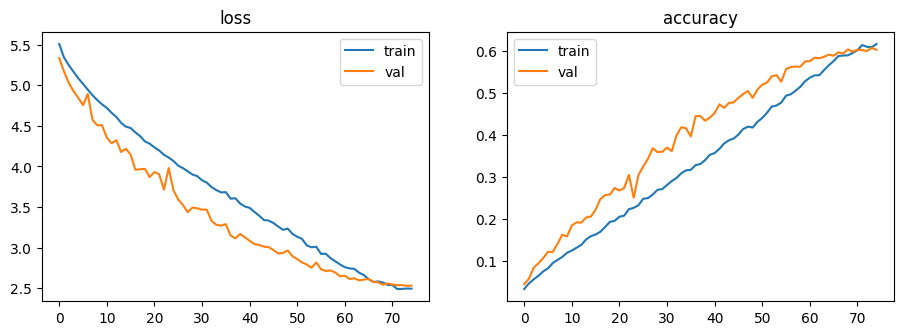

In [25]:
plot_history(history, 'loss', 'accuracy')

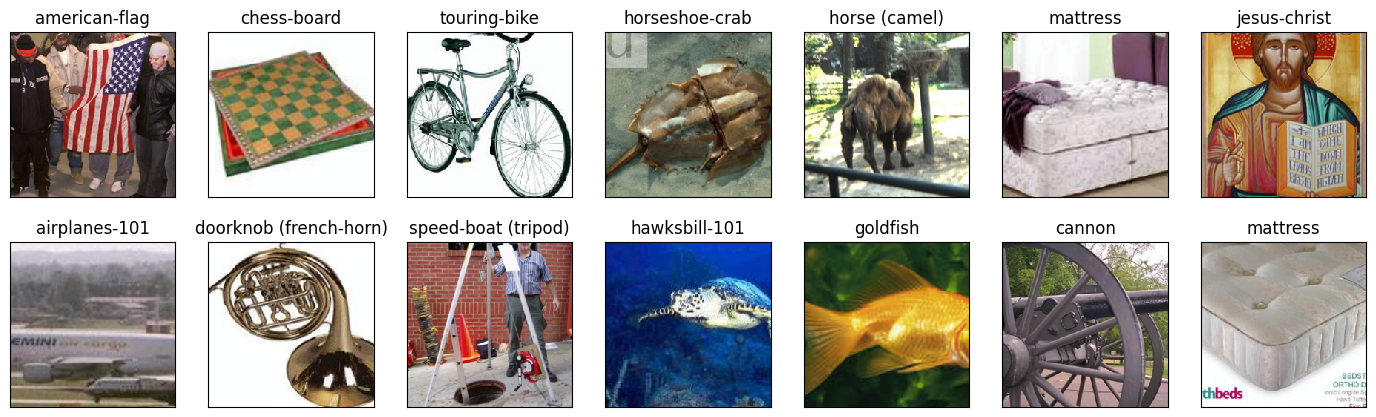

In [30]:
plot_results(resnet, val_loader, 14)

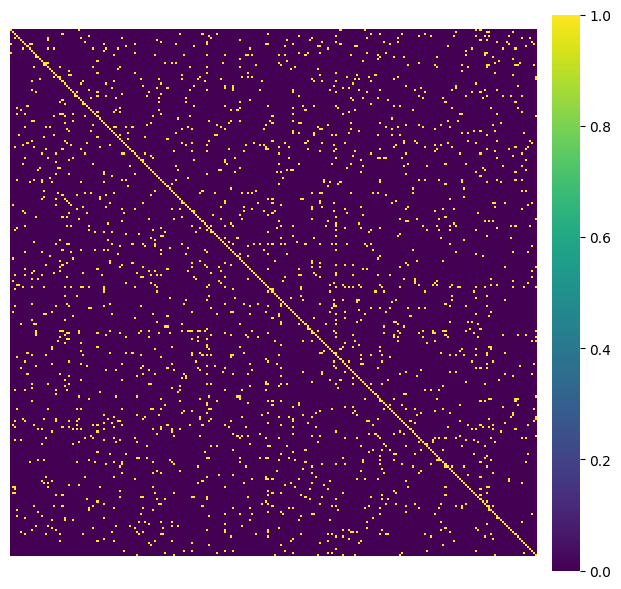

In [27]:
plot_confusion_matrix(resnet, val_loader)

In [26]:
torch.save(resnet, 'drive/MyDrive/aidl/lab7/myresnet.pkl')

Экспорт в ONNX и сравнение точности. Результаты совпадают

In [33]:
ex_input = torch.zeros(32, 3, 224, 224, device=device)
torch.onnx.export(resnet, ex_input, 'drive/MyDrive/aidl/lab7/myresnet.onnx', 
                  input_names = ['input'], output_names = ['output'], 
                  dynamic_axes={'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}})

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [35]:
session = onnxrt.InferenceSession('drive/MyDrive/aidl/lab7/myresnet.onnx', providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider'])
acc = validate_onnx(session, val_loader)
print(f'\nONNX accuracy: {acc:.4f}')

100%|##########| 184/184 [00:37<00:00,  4.94it/s]


ONNX accuracy: 0.6020


## Список использованных источников

1. Deep Residual Learning for Image Recognition. - URL: https://arxiv.org/abs/1512.03385
2. Revisiting ResNets: Improved Training and Scaling Strategies. - URL: https://arxiv.org/abs/2103.07579
3. PyTorch - How to Train State-Of-The-Art Models Using TorchVision’s Latest Primitives. - URL: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/
4. Towards Data Science - Cutout, Mixup, and Cutmix: Implementing Modern Image Augmentations in PyTorch. - URL: https://towardsdatascience.com/cutout-mixup-and-cutmix-implementing-modern-image-augmentations-in-pytorch-a9d7db3074ad